In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

from tqdm.auto import tqdm

from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

import re

In [ ]:
!nvidia-smi

Mon Nov 21 20:30:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    32W /  70W |   5922MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
input_data = pd.read_csv('/content/data_f.txt', sep='\n', names=['Input'])
output_data = pd.read_csv('/content/label_f.txt', sep='\n', names=['Output'])

#input_data = pd.read_csv('/content/data_new.txt', sep='\n', names=['Input'])
#output_data = pd.read_csv('/content/label_new.txt', sep='\n', names=['Output'])

#input_data = pd.read_csv('/content/sparknotes_modern_asyoulikeit.txt', sep='\n', names=['Input'])
#output_data = pd.read_csv('/content/sparknotes_original_asyoulikeit.txt', sep='\n', names=['Output'])

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2', pad_token_id=tokenizer.eos_token_id)

tokenizer.pad_token = tokenizer.eos_token

In [ ]:
input_dataset = []
output_dataset = []
dataset = []

for row in input_data['Input']:
    input_dataset.append(row)

for row in output_data['Output']:
    output_dataset.append(row)

for i in range(len(input_dataset)):
    data = input_dataset[i]+' = '+output_dataset[i]
    if(len(data)>200):
        continue
    if(len(data)<20):
        continue
    dataset.append(data)

In [ ]:
for i in range(100):
    print(dataset[i])

Now, beautiful Hippolyta , the hour of our wedding is speeding closer. = Now, fair Hippolyta, our nuptial hour Draws on apace.
Four days will quickly pass and turn to night. = Four days will quickly steep themselves in night.
And each night, we will dream away the time. = Four nights will quickly dream away the time.
Go, Philostrate, get the young people of Athens in the mood to celebrate. = Go, Philostrate, Stir up the Athenian youth to merriments.
Wake up the lively and swift spirit of fun. = Awake the pert and nimble spirit of mirth.
Joy to you, Theseus  our famous and distinguished duke! = Happy be Theseus, our renownèd duke.
Thank you, dear Egeus. = Thanks, good Egeus.
What’s going on with you? = What’s the news with thee?
I’ve come to you full of anger, to protest against the actions of my daughter, Hermia. = Full of vexation come I with complaint Against my child, my daughter Hermia.
Step forward, Demetrius. = Stand forth, Demetrius.
My noble lord Theseus, this man, Demetrius, h

In [ ]:
print(len(input_dataset))
print(len(output_dataset))
print(len(dataset))

40856
41614
39175


In [ ]:
print(dataset[0])

Now, beautiful Hippolyta , the hour of our wedding is speeding closer. = Now, fair Hippolyta, our nuptial hour Draws on apace.


In [ ]:
class ShakespeareDataset(Dataset):

    def __init__(self, encodings):
        self.encodings = encodings
        
    def __getitem__(self, index):
        
        x = {key: torch.tensor(val[index]) for key,val in self.encodings.items()}
        return x

    def __len__(self):
        return len(self.encodings['input_ids'])

In [ ]:
train_dataset = ShakespeareDataset(tokenizer(dataset[:1000], truncation=True, padding=True))
val_dataset = ShakespeareDataset(tokenizer(dataset[1000:1100], truncation=True, padding=True))


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False)

val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [ ]:
tokenizer.decode(train_dataset[0]['input_ids'])

'Now, beautiful Hippolyta, the hour of our wedding is speeding closer. = Now, fair Hippolyta, our nuptial hour Draws on apace.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>'

In [ ]:
optimizer = AdamW(model.parameters(), lr=8e-5)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = model.to(device)

In [ ]:
for batch in train_dataloader:
    print(batch['input_ids'])
    break

tensor([[ 3844,    11,  4950, 33812,  3366,  8326,   837,   262,  1711,   286,
           674, 10614,   318, 26347,  5699,    13,   796,  2735,    11,  3148,
         33812,  3366,  8326,    11,   674, 14364,   457,   498,  1711, 15315,
            82,   319,  2471,   558,    13, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256],
        [15137,  1528,   481,  2952,  1208,   290,  1210,   284,  1755,    13,
           796,  6675,  1528,   481,  2952, 14559,  2405,   287,  1755,    13,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256],
    

In [ ]:
train_loss_epochs = []
val_loss_epochs = []

In [ ]:
epochs = 10

In [ ]:
for epoch in range(epochs):

    print("Epoch:",epoch+1)

    train_loss = 0
    
    model.train()
    for batch in tqdm(train_dataloader):
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        #print(labels.shape)
        #print(batch)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
        #outputs = model(x['input_ids'],y['input_ids'])
        loss = outputs.loss

        train_loss += loss
        train_loss = train_loss.detach()

        loss.backward()

        optimizer.step()

        optimizer.zero_grad()

    print("Training Loss =",train_loss.cpu()/len(train_dataloader))

    train_loss_epochs.append(train_loss.cpu()/len(train_dataloader))



    val_loss = 0

    model.eval()
    for batch in tqdm(val_dataloader):

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        #print(labels.shape)
        #print(batch)
        
        with torch.no_grad():
            #outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
            #outputs = model(x['input_ids'],y['input_ids'])
            val_loss += outputs.loss
        
    print("Validation Loss =",val_loss/len(val_dataloader))

    val_loss_epochs.append(val_loss.cpu()/len(val_dataloader))

Epoch: 1


  0%|          | 0/125 [00:00<?, ?it/s]

Training Loss = tensor(1.5040)


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss = tensor(1.9481, device='cuda:0')
Epoch: 2


  0%|          | 0/125 [00:00<?, ?it/s]

Training Loss = tensor(1.1312)


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss = tensor(1.9374, device='cuda:0')
Epoch: 3


  0%|          | 0/125 [00:00<?, ?it/s]

Training Loss = tensor(0.9811)


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss = tensor(1.9694, device='cuda:0')
Epoch: 4


  0%|          | 0/125 [00:00<?, ?it/s]

Training Loss = tensor(0.8438)


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss = tensor(2.0377, device='cuda:0')
Epoch: 5


  0%|          | 0/125 [00:00<?, ?it/s]

Training Loss = tensor(0.7121)


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss = tensor(2.1628, device='cuda:0')
Epoch: 6


  0%|          | 0/125 [00:00<?, ?it/s]

Training Loss = tensor(0.5834)


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss = tensor(2.3286, device='cuda:0')
Epoch: 7


  0%|          | 0/125 [00:00<?, ?it/s]

Training Loss = tensor(0.4706)


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss = tensor(2.5250, device='cuda:0')
Epoch: 8


  0%|          | 0/125 [00:00<?, ?it/s]

Training Loss = tensor(0.3709)


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss = tensor(2.6532, device='cuda:0')
Epoch: 9


  0%|          | 0/125 [00:00<?, ?it/s]

Training Loss = tensor(0.2986)


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss = tensor(2.8277, device='cuda:0')
Epoch: 10


  0%|          | 0/125 [00:00<?, ?it/s]

Training Loss = tensor(0.2530)


  0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss = tensor(2.9224, device='cuda:0')


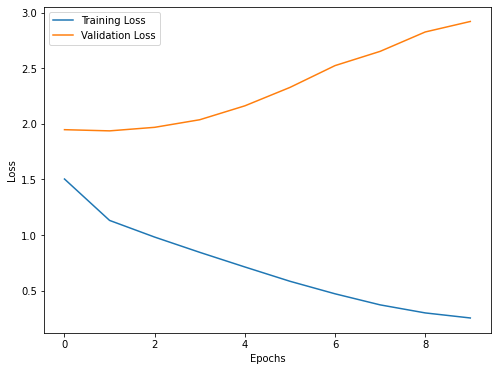

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(torch.arange(epochs) , train_loss_epochs, label='Training Loss');
plt.plot(torch.arange(epochs) , val_loss_epochs, label='Validation Loss');
plt.xlabel('Epochs');
plt.ylabel('Loss');
plt.legend();

In [ ]:
input = tokenizer.encode(input_dataset[3]+'=')
#input

#input = tokenizer.encode('Hello, how are you? = ')

In [ ]:
def calculate_bleu(data):
    
    data = data.split('=')
    input = data[0]
    target = data[1].strip()
    input = tokenizer.encode(input+' =')
    output_final = []
    
    for i in range(len(target.split())+5):
        output = model(input_ids=torch.tensor([input]).to(device))
        input.append(torch.argmax(output.logits[0],dim=1)[-1].item())
        output_final.append(torch.argmax(output.logits[0],dim=1)[-1].item())
    
    decoded_output = tokenizer.decode(torch.tensor(input),skip_special_tokens=True)
    decoded_output = decoded_output.split('=')[1].strip()
    
    if(len(target.split())==1):
        weights = (1,)
    elif(len(target.split())==2):
        weights = (1,1)
    elif(len(target.split())==3 or len(target.split())==4):
        weights = (1,1,1)
    else:
        weights = (1,1,1,1)

    decoded_output = re.sub('[^ A-Za-z0-9]+', '', decoded_output)
    target = re.sub('[^ A-Za-z0-9]+', '', target)

    bleu = round(sentence_bleu([target.split()],decoded_output.split(),weights=weights),4)

    if bleu<1:
        print(len(target.split()))
        print(weights)
        print(target)
        print(decoded_output)
        print(bleu)

    return bleu

In [ ]:
avg_bleu = 0
for i in range(1000,1100):
    avg_bleu += calculate_bleu(dataset[i])
avg_bleu = avg_bleu/100

print(avg_bleu)

6
(1, 1, 1, 1)
Tis not his fault the spark
I will plead with you highness That in such
0
4
(1, 1, 1)
O tis brave wars
Do you know what she is madam
0


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

7
(1, 1, 1, 1)
Most admirable I have seen those wars
Tis not unknown to you madam I
0.0
19
(1, 1, 1, 1)
I am commanded here and kept a coil with Too young and the next year and tis too early  
Why madam you must attend to her command
0
9
(1, 1, 1, 1)
An thy mind stand tot boy steal away bravely
What I am told is the kings command
0
5
(1, 1, 1, 1)
Theres honour in the theft
You know Helena I am a poor friend
0
3
(1, 1, 1)
Commit it count
Whats pity
0
7
(1, 1, 1, 1)
I am your accessary and so farewell
Why madam you dare go so boldly
0.0
11
(1, 1, 1, 1)
I grow to you and our parting is a tortured body
Your commendations madam
0
2
(1, 1)
Farewell captain
Now the door is down that parted
0
3
(1, 1, 1)
Sweet Monsieur Parolles
What gentlewoman
0
8
(1, 1, 1, 1)
Noble heroes my sword and yours are kin
I am sent with broom before To sweep the dust behind the door
0
4
(1, 1, 1)
We shall noble captain
What say you madam
0
7
(1, 1, 1, 1)
Mars dote on you for his novices
My lord the choice was yours

In [ ]:
ref = 'hello, how are you'
tar = 'hello how are you'

ref = re.sub('[^ A-Za-z0-9]+', '', ref)
print(ref)
bleu = round(sentence_bleu([ref.split()],tar.split(),weights=(1,1,1,1)),4)
print(bleu)

hello how are you
1.0


In [ ]:
n = 2

data = dataset[n]

data = data.split('=')
input = data[0]
target = data[1].strip()
input = tokenizer.encode(input+' =')
output_final = []

for i in range(len(target.split())+5):
    output = model(input_ids=torch.tensor([input]).to(device))
    input.append(torch.argmax(output.logits[0],dim=1)[-1].item())
    output_final.append(torch.argmax(output.logits[0],dim=1)[-1].item())

decoded_output = tokenizer.decode(torch.tensor(input),skip_special_tokens=True)
decoded_output = decoded_output.split('=')[1].strip()

print(dataset[n])
print()
print(decoded_output)

And each night, we will dream away the time. = Four nights will quickly dream away the time.

Four nights will quickly dream away the time.


In [ ]:
input_new = input
output_final = []
for i in range(len(input)):
    output = model(input_ids=torch.tensor([input_new]).to(device))
    input_new.append(torch.argmax(output.logits[0],dim=1)[-1].item())
    output_final.append(torch.argmax(output.logits[0],dim=1)[-1].item())

In [ ]:
print()

In [ ]:
tokenizer.decode(torch.tensor(output_final))

'<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>'

In [ ]:
tokenizer.decode(torch.tensor(output_final))

'<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>'

In [ ]:
input 

[1870,
 2582,
 262,
 8824,
 588,
 257,
 8465,
 9563,
 8308,
 17157,
 656,
 257,
 12133,
 287,
 262,
 6766,
 481,
 804,
 866,
 319,
 262,
 1755,
 286,
 674,
 10614,
 14395,
 13,
 28,
 6675,
 12513,
 481,
 2952,
 14559,
 2405,
 287,
 1755,
 13,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256]

In [ ]:
output = model.generate(input_ids=torch.tensor([input]).to(device), do_sample=True, max_new_tokens=20)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


In [ ]:
tokenizer.decode(output[0])

'And soon the moon like a silver bow newly bent into a curve in the sky will look down on the night of our wedding celebration.= Four nights will quickly steep themselves in night.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><

In [ ]:
torch.save(model.state_dict(), '/content/gpt2_training_2_100samples_overfit.pt')

In [ ]:
from google.colab import drive

import shutil

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
shutil.copy("/content/gpt2_training_2_100samples_overfit.pt","/content/drive/MyDrive/ECE1786_Project/Models")

'/content/drive/MyDrive/ECE1786_Project/Models/gpt2_training_2_100samples_overfit.pt'